In [4]:
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from iris.experimental.equalise_cubes import equalise_attributes

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '2.2km'
trim_to_leeds = False

# # Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})


##################################################################
# FOR ONE YEAR AT A TIME
##################################################################
year = 2011

# Create directory to store outputs in and get general filename to load files from
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
    general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
elif resolution == '2.2km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/*'      
elif resolution == '12km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/*'      
if not os.path.isdir(ddir):
    os.makedirs(ddir)

# GET LIST OF ALL FILENAMES FOR THIS YEAR
filenames =[]
# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    # print(filename)
    filenames.append(filename)
print(f"loading {len(filenames)} filenames")
sorted_list = sorted(filenames)

loading 92 filenames


In [6]:
monthly_cubes_list = iris.load(sorted_list, in_jja)


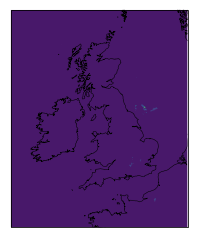

In [8]:
### Check plotting
iplt.contourf(monthly_cubes_list[10][0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

getting mask


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


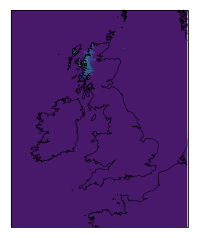

In [12]:
    ### Check plotting
    iplt.contourf(cube_jja[10])
    plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

    ##################################################################
    # MASK OUT VALUES OVER THE SEA
    ##################################################################
    print("getting mask")
    lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
    lsm = lsm_cubes_list[0]
    lsm_nn =lsm.regrid(cube_jja_uk,iris.analysis.Nearest())   


    ### Convert land sea mask to a cube of the same shape as our data 
    # Convert to shape of cube
    broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_jja_uk.shape)
    # Convert to integer
    broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
    # Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
    reversed_array = ~broadcasted_lsm_data_int.astype(bool)

    ### Mask the cube using the lsm cube
    masked_cube = iris.util.mask_cube(cube_jja_uk, reversed_array)


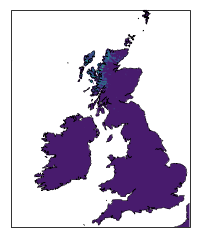

In [15]:
iplt.contourf(masked_cube[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:


##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})


##################################################################
# FOR ONE YEAR AT A TIME
##################################################################
for year in range(2016, 2021):
    print(year)

    # Create directory to store outputs in and get general filename to load files from
    if resolution =='1km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
        general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
    elif resolution == '2.2km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/*'      
    elif resolution == '12km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/*'      
    if not os.path.isdir(ddir):
        os.makedirs(ddir)

    # GET LIST OF ALL FILENAMES FOR THIS YEAR
    filenames =[]
    # Find all files in directory which start with this string
    for filename in glob.glob(general_filename):
        # print(filename)
        filenames.append(filename)
    print(f"loading {len(filenames)} filenames")
    sorted_list = sorted(filenames)

    # LOAD THE DATA
    monthly_cubes_list = iris.load(sorted_list, in_jja)
      
    ##################################################################
    # CLEAN AND JOIN THE DATA
    ##################################################################
    # Get rid of any files which don't have the time dimension
    is_to_delete = []
    for i in range(0,len(monthly_cubes_list) ):
        if len(monthly_cubes_list[i].shape) <3:
            is_to_delete.append(i)
    for i in is_to_delete:
        print(f"deleting cube {i} as it only had one dimension")
        del monthly_cubes_list[i] 

    for i in range(0, len(monthly_cubes_list)):
        try:
            monthly_cubes_list[i].coord('forecast_period')
            monthly_cubes_list[i].remove_coord('forecast_period')
        except:
            pass
        try:
            monthly_cubes_list[i].coord('forecast_reference_time')
            monthly_cubes_list[i].remove_coord('forecast_reference_time')
        except:
            pass           
        try:
            monthly_cubes_list[i].coord('hour')
            monthly_cubes_list[i].remove_coord('hour')
        except:
            pass   

    # Try to make attributes the same
    iris.util.equalise_attributes(monthly_cubes_list)   
    
    # CONVERT TO FLOAT64
    for i in range(0, len(monthly_cubes_list)):
        monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')

    cube_jja = monthly_cubes_list.concatenate_cube()

    print(cube_jja.coord('time')[0])
    print(cube_jja.coord('time')[-1])


    ##################################################################
    # TRIM TO UK
    ##################################################################
    cube_jja_uk = trim_to_bbox_of_region_regriddedobs(cube_jja, uk_gdf)

    ### Check plotting
    iplt.contourf(cube_jja[10])
    plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

    ##################################################################
    # MASK OUT VALUES OVER THE SEA
    ##################################################################
    print("getting mask")
    lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
    lsm = lsm_cubes_list[0]
    lsm_nn =lsm.regrid(cube_jja_uk,iris.analysis.Nearest())   


    ### Convert land sea mask to a cube of the same shape as our data 
    # Convert to shape of cube
    broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_jja_uk.shape)
    # Convert to integer
    broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
    # Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
    reversed_array = ~broadcasted_lsm_data_int.astype(bool)

    ### Mask the cube using the lsm cube
    masked_cube = iris.util.mask_cube(cube_jja_uk, reversed_array)


    ### Check plotting
    iplt.contourf(masked_cube[0])
    plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);


    # ### Save to check with ncview
    # Run linux ncview f'masked-cube-{year}-{resolution}.nc'
    ddir + f'{year}_maskedcube.nc'
    iris.save(masked_cube, ddir + f'{year}_maskedcube.nc')



    print(f"Min value is {np.nanmin(masked_cube.data)}")

    ##################################################################
    # COMPRESS DATA (FLATTEN AND REMOVE MASKED VALUES)
    ##################################################################

    compressed = masked_cube.data.compressed()
    compressed.shape[0]
    # REMOVE NAN VALUES
    #compressed = compressed[~np.isnan(compressed)]
    
    ########
    # Get the times
    ########
    # Step 2: Get the indices of the non-masked values in the original data
    non_masked_indices = np.where(~masked_cube.data.mask)

    # Step 3: Extract corresponding time values
    time_values = masked_cube.coord('time').points[non_masked_indices[0]]
    np.save(ddir + f'{year}_timevalues.npy', time_values) 
        

    # ### Check length of data from flattening it before compressing (shows we have lost 60% values)
    # notcompressed = masked_cube.data.flatten()
    # (compressed.shape[0] / (notcompressed.shape[0] + compressed.shape[0])) *100

    # ### Sense check min/max values
    print(np.nanmin(compressed))
    print(np.nanmax(compressed))

    less0 = compressed[compressed <0]
    more0 = compressed[compressed >0]

    ##################################################################
    # SAVE TO NUMPY ARRAY
    ##################################################################
    np.save(ddir + f'{year}_compressed.npy', compressed) 


ERROR:fiona._env:PROJ: proj_identify: /nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: /nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


2016
loading 92 filenames
DimCoord([2016-06-01 00:12:30], bounds=[[2016-06-01 00:00:00, 2016-06-01 00:25:00]], standard_name='time', calendar='gregorian', var_name='time')
DimCoord([2016-08-31 23:42:30], bounds=[[2016-08-31 23:30:00, 2016-08-31 23:55:00]], standard_name='time', calendar='gregorian', var_name='time')
getting mask
Min value is 0.0
0.0
302.5833333333333
2017
loading 92 filenames
DimCoord([2017-06-01 00:12:30], bounds=[[2017-06-01 00:00:00, 2017-06-01 00:25:00]], standard_name='time', calendar='gregorian', var_name='time')
DimCoord([2017-08-31 23:42:30], bounds=[[2017-08-31 23:30:00, 2017-08-31 23:55:00]], standard_name='time', calendar='gregorian', var_name='time')
getting mask
Min value is 0.0
0.0
438.8541666666667
2018
loading 92 filenames
DimCoord([2018-06-01 00:12:30], bounds=[[2018-06-01 00:00:00, 2018-06-01 00:25:00]], standard_name='time', calendar='gregorian', var_name='time')
DimCoord([2018-08-31 23:42:30], bounds=[[2018-08-31 23:30:00, 2018-08-31 23:55:00]], sta

In [146]:
# Step 3: Extract corresponding time values
time_values = masked_cube.coord('time').points[non_masked_indices[0]]
np.save(ddir + f'{year}_timevalues.npy', time_values) 


# ### Check length of data from flattening it before compressing (shows we have lost 60% values)
# notcompressed = masked_cube.data.flatten()
# (compressed.shape[0] / (notcompressed.shape[0] + compressed.shape[0])) *100

# ### Sense check min/max values
print(np.nanmin(compressed))
print(np.nanmax(compressed))

less0 = compressed[compressed <0]
more0 = compressed[compressed >0]

##################################################################
# SAVE TO NUMPY ARRAY
##################################################################
np.save(ddir + f'{year}_compressed.npy', compressed) 

0.0
202.921875


In [ ]:
##################################################################
# This Script:
#    - Gets all 30 mins radar files for one year
#    - Joins them and masks out values over the sea
#    - Gets a 1D array of the data and removes masked out (over the sea
#      values) and np.nan values
##################################################################


##################################################################
# SET UP ENVIRONMENT
##################################################################
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from iris.experimental.equalise_cubes import equalise_attributes

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '2.2km'
trim_to_leeds = False

# # Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})


##################################################################
# FOR ONE YEAR AT A TIME
##################################################################
for year in range(2011, 2012):
    print(year)

    # Create directory to store outputs in and get general filename to load files from
    if resolution =='1km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
        general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
    elif resolution == '2.2km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/*'      
    elif resolution == '12km':
        ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
        general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/*'      
    if not os.path.isdir(ddir):
        os.makedirs(ddir)

    # GET LIST OF ALL FILENAMES FOR THIS YEAR
    filenames =[]
    # Find all files in directory which start with this string
    for filename in glob.glob(general_filename):
        # print(filename)
        filenames.append(filename)
    print(len(filenames))
    sorted_list = sorted(filenames)

    # LOAD THE DATA
    monthly_cubes_list = iris.load(sorted_list, in_jja)
      
    ##################################################################
    # CLEAN AND JOIN THE DATA
    ##################################################################
    # Get rid of any files which don't have the time dimension
    is_to_delete = []
    for i in range(0,len(monthly_cubes_list) ):
        if len(monthly_cubes_list[i].shape) <3:
            is_to_delete.append(i)
        for i in is_to_delete:
            print(i)
            del monthly_cubes_list[i] 

    for i in range(0, len(monthly_cubes_list)):
        try:
            monthly_cubes_list[i].coord('forecast_period')
            monthly_cubes_list[i].remove_coord('forecast_period')
        except:
            pass
        try:
            monthly_cubes_list[i].coord('forecast_reference_time')
            monthly_cubes_list[i].remove_coord('forecast_reference_time')
        except:
            pass           
        try:
            monthly_cubes_list[i].coord('hour')
            monthly_cubes_list[i].remove_coord('hour')
        except:
            pass   

    # Try to make attributes the same
    iris.util.equalise_attributes(monthly_cubes_list)   
    
    # CONVERT TO FLOAT64
    for i in range(0, len(monthly_cubes_list)):
        monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')

    cube_jja = monthly_cubes_list.concatenate_cube()

    print(cube_jja.coord('time')[0])
    print(cube_jja.coord('time')[-1])


    ##################################################################
    # TRIM TO UK
    ##################################################################
    cube_jja_uk = trim_to_bbox_of_region_regriddedobs(cube_jja, uk_gdf)

    ### Check plotting
    iplt.contourf(cube_jja[10])
    plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

    ##################################################################
    # MASK OUT VALUES OVER THE SEA
    ##################################################################
    print("getting mask")
    lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
    lsm = lsm_cubes_list[0]
    lsm_nn =lsm.regrid(cube_jja_uk,iris.analysis.Nearest())   


    ### Convert land sea mask to a cube of the same shape as our data 
    # Convert to shape of cube
    broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_jja_uk.shape)
    # Convert to integer
    broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
    # Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
    reversed_array = ~broadcasted_lsm_data_int.astype(bool)

    ### Mask the cube using the lsm cube
    masked_cube = iris.util.mask_cube(cube_jja_uk, reversed_array)


    ### Check plotting
    iplt.contourf(masked_cube[0])
    plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);


    # ### Save to check with ncview
    # Run linux ncview f'masked-cube-{year}-{resolution}.nc'
    ddir + f'{year}_maskedcube.nc'
    iris.save(masked_cube, ddir + f'{year}_maskedcube.nc')



    print(f"Min value is {np.nanmin(masked_cube.data)}")

    ##################################################################
    # COMPRESS DATA (FLATTEN AND REMOVE MASKED VALUES)
    ##################################################################

    compressed = masked_cube.data.compressed()
    compressed.shape[0]
    # REMOVE NAN VALUES
    compressed = compressed[~np.isnan(compressed)]


    # ### Check length of data from flattening it before compressing (shows we have lost 60% values)
    # notcompressed = masked_cube.data.flatten()
    # (compressed.shape[0] / (notcompressed.shape[0] + compressed.shape[0])) *100

    # ### Sense check min/max values
    print(np.nanmin(compressed))
    print(np.nanmax(compressed))

    less0 = compressed[compressed <0]
    more0 = compressed[compressed >0]

    ##################################################################
    # SAVE TO NUMPY ARRAY
    ##################################################################
    np.save(ddir + f'{year}_compressed.npy', compressed) 

